Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [1]:
%%capture
! pip install git+https://github.com/LegrandNico/metadPy.git

In [2]:
import numpy as np
import pandas as pd
from metadPy.mle import metad, fit_metad
from metadPy import load_dataset
from metadPy.plotting import plot_confidence, plot_roc
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("talk")

In this notebook, we are going to estimate meta-*d'* using Maximum Likelihood Estimation ([MLE](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation)) [**1**, **2**] using the function implemented in [metadPy](https://github.com/LegrandNico/metadPy). This function is directly adapted from the transcription of the Matlab `fit_meta_d_MLE.m` [**3**] by Alan Lee that can be retrieved [here](http://www.columbia.edu/~bsm2105/type2sdt/).

We are going to see, however, that [metadPy](https://github.com/LegrandNico/metadPy) greatly simplifies the preprocessing of raw data, letting the user fit the model for many participants/groups/conditions from the results data frame in a single command call. Another advantage here is that the python code supporting the model fitting is optimized using [Numba](http://numba.pydata.org/), which greatly improves its performance.

# Fitting at the subject level

## From response-signal arrays

In [3]:
# Create responses data
nR_S1 = np.array([52, 32, 35, 37, 26, 12, 4, 2])
nR_S2 = np.array([2, 5, 15, 22, 33, 38, 40, 45])

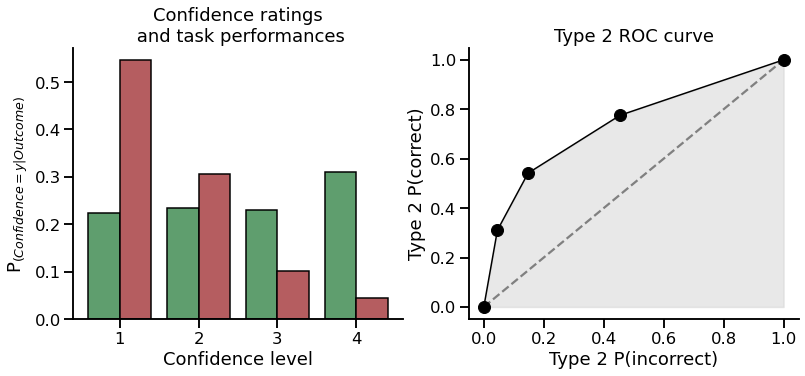

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
plot_confidence(nR_S1, nR_S2, ax=axs[0])
plot_roc(nR_S1, nR_S2, ax=axs[1])
sns.despine()

The model is fitted using the `metadPy.mle.metad()` function. This function accepts response-signal arrays as input if the data comes from a single subject.

In [5]:
output = metad(nR_S1=nR_S1, nR_S2=nR_S2)

Estimate meta-d' using maximum likelihood estimation (MLE).
- n Subjects: 1
- n Conditions: 1
- n Groups: 1
... Using padding to avoid fitting errors.
Fitting model on subject: Subject 1: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


In [6]:
output

,dprime,meta_d,m_ratio,m_diff
0,1.534994,1.63376,1.064343,0.098766


The function will return a data frame containng the `dprime`, `metad`, `m_ratio` and `m_diff` scores for this participant.

## From a data frame
To simplify the preprocessing steps, the model can also be fitted directly from the raw result data frame. The data frame should contain the following columns:

* `Stimuli`: Which of the two stimuli was presented [0 or 1].
* `Response` or `Accuracy`: The response provided by the participant or the accuracy [0 or 1].
* `Confidence`: The confidence level [can be continuous or discrete].

In addition, it can also integrate:
* `Subject`: The subject ID.
* `within` or `between`: The condition or the group ID (if many groups or conditions were used).

Note that the MLE method will always fit the participant separately (i.e. in a non-hierarchical way), which means that the results will be the same by fitting each participant and condition separately (e.g. in a for loop).

In [7]:
df = load_dataset("rm")
df.head()

,Stimuli,Responses,Accuracy,Confidence,nTrial,Subject,Condition
0,0,0,1,4,0,0,0
1,1,1,1,4,1,0,0
2,0,1,0,4,2,0,0
3,1,0,0,1,3,0,0
4,1,1,1,2,4,0,0


In [8]:
subject_fit = metad(
    data=df[df.Subject==0].copy(),
    nRatings=4,
    stimuli="Stimuli",
    accuracy="Accuracy",
    confidence="Confidence",
    padding=True,
)

Estimate meta-d' using maximum likelihood estimation (MLE).
- n Subjects: 1
- n Conditions: 1
- n Groups: 1
... Using padding to avoid fitting errors.
Fitting model on subject: Subject 1: 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


In [9]:
subject_fit.head()

,dprime,meta_d,m_ratio,m_diff
0,0.999247,0.781983,0.782573,-0.217264


# Fitting at the group level

## Using a dataframe

In [10]:
group_fit = metad(
    data=df,
    nRatings=4,
    stimuli="Stimuli",
    accuracy="Accuracy",
    confidence="Confidence",
    subject="Subject",
    padding=True,
    within="Condition"
)

Estimate meta-d' using maximum likelihood estimation (MLE).
- n Subjects: 20
- n Conditions: 2
- n Groups: 1
... Using padding to avoid fitting errors.
Fitting model on subject: 19: 100%|██████████| 20/20 [00:06<00:00,  2.91it/s]


In [11]:
group_fit.head()

,dprime,meta_d,m_ratio,m_diff,Subject,Condition
0,0.959244,0.739642,0.771068,-0.219601,0,0
0,1.006310,0.790893,0.785934,-0.215417,0,1
0,1.117543,1.084441,0.970379,-0.033103,1,0
0,0.967871,0.869539,0.898404,-0.098332,1,1
0,0.792528,0.670130,0.845560,-0.122398,2,0


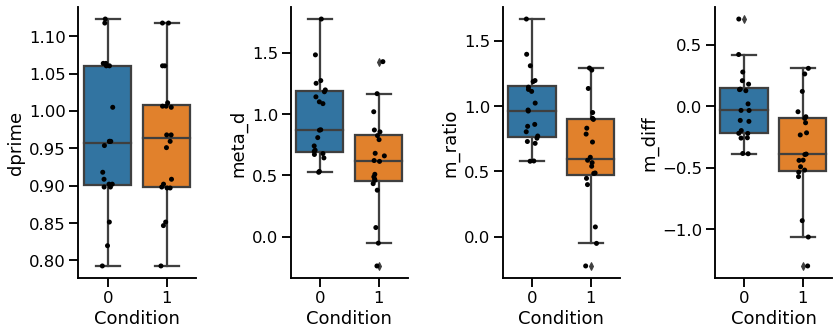

In [12]:
_, axs = plt.subplots(1, 4, figsize=(12, 5), sharex=True)

sns.boxplot(data=group_fit, x="Condition", y="dprime", ax=axs[0])
sns.stripplot(data=group_fit, x="Condition", y="dprime", color="k", ax=axs[0])

sns.boxplot(data=group_fit, x="Condition", y="meta_d", ax=axs[1])
sns.stripplot(data=group_fit, x="Condition", y="meta_d", color="k", ax=axs[1])

sns.boxplot(data=group_fit, x="Condition", y="m_ratio", ax=axs[2])
sns.stripplot(data=group_fit, x="Condition", y="m_ratio", color="k", ax=axs[2])

sns.boxplot(data=group_fit, x="Condition", y="m_diff", ax=axs[3])
sns.stripplot(data=group_fit, x="Condition", y="m_diff", color="k", ax=axs[3])

plt.tight_layout()
sns.despine()

# References

**[1]** Maniscalco, B., & Lau, H. (2014). Signal Detection Theory Analysis of Type 1 and Type 2 Data: Meta-d′, Response-Specific Meta-d′, and the Unequal Variance SDT Model. In The Cognitive Neuroscience of Metacognition (pp. 25–66). Springer Berlin Heidelberg. https://doi.org/10.1007/978-3-642-45190-4_3 

**[2]** Fleming, S. M., & Lau, H. C. (2014). How to measure metacognition. Frontiers in Human Neuroscience, 8. https://doi.org/10.3389/fnhum.2014.00443

**[3]** Maniscalco, B., & Lau, H. (2012). A signal detection theoretic approach for estimating metacognitive sensitivity from confidence ratings. Consciousness and Cognition, 21(1), 422–430. doi:10.1016/j.concog.2011.09.021